In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.layers import Dense, InputLayer, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

#### Load Dataset and Perform EDA

In [27]:
dataset = pd.read_csv('datasets/cleaned/merged_fx_dataset.csv')
dataset.head()

,Date,Buying,Selling,MidRate,MPR,FoodInflation,GhInflationRate,NonFoodInflation,BrentOil,Cocoa,...,GhCompositeIndex,FXDeposits,InterbankWeightedAvg,T-bill-182,T-bill-91,PrivateSectorCredit,TradeBalance,USGDP,USInflationRate,USInterestRate
0,2022-12-01,13.0973,13.1105,13.1039,27.0,59.7,54.1,49.9,81.34,2538.57,...,0.00,45124.35,25.51,36.23,35.48,63753.45,450.75,22249.459,116.977,3.83
1,2022-11-30,13.0978,13.1110,13.1044,27.0,55.3,50.3,46.5,90.38,2469.10,...,-6.16,66496.63,25.80,35.68,34.62,73744.05,444.36,22249.459,116.554,3.83
2,2022-11-29,13.0980,13.1112,13.1046,27.0,55.3,50.3,46.5,90.38,2469.10,...,-6.16,66496.63,25.80,35.68,34.62,73744.05,444.36,22249.459,116.554,3.83
3,2022-11-28,13.0982,13.1114,13.1048,27.0,55.3,50.3,46.5,90.38,2469.10,...,-6.16,66496.63,25.80,35.68,34.62,73744.05,444.36,22249.459,116.554,3.83
4,2022-11-25,13.0985,13.1117,13.1051,27.0,55.3,50.3,46.5,90.38,2469.10,...,-6.16,66496.63,25.80,35.68,34.62,73744.05,444.36,22249.459,116.554,3.83


In [28]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3703 entries, 0 to 3702
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  3703 non-null   object 
 1   Buying                3703 non-null   float64
 2   Selling               3701 non-null   float64
 3   MidRate               3701 non-null   float64
 4   MPR                   3703 non-null   float64
 5   FoodInflation         3703 non-null   float64
 6   GhInflationRate       3703 non-null   float64
 7   NonFoodInflation      3703 non-null   float64
 8   BrentOil              3703 non-null   float64
 9   Cocoa                 3703 non-null   float64
 10  Gold                  3703 non-null   float64
 11  GhInterestRate        3703 non-null   float64
 12  NetForeignAssets      3703 non-null   float64
 13  NIR                   3703 non-null   float64
 14  Imports               3703 non-null   float64
 15  Exports              

In [29]:
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3703 entries, 0 to 3702
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  3703 non-null   datetime64[ns]
 1   Buying                3703 non-null   float64       
 2   Selling               3701 non-null   float64       
 3   MidRate               3701 non-null   float64       
 4   MPR                   3703 non-null   float64       
 5   FoodInflation         3703 non-null   float64       
 6   GhInflationRate       3703 non-null   float64       
 7   NonFoodInflation      3703 non-null   float64       
 8   BrentOil              3703 non-null   float64       
 9   Cocoa                 3703 non-null   float64       
 10  Gold                  3703 non-null   float64       
 11  GhInterestRate        3703 non-null   float64       
 12  NetForeignAssets      3703 non-null   float64       
 13  NIR               

In [31]:
dataset.drop(columns=['Selling', 'MidRate'], inplace=True)

In [32]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3703 entries, 0 to 3702
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  3703 non-null   datetime64[ns]
 1   Buying                3703 non-null   float64       
 2   MPR                   3703 non-null   float64       
 3   FoodInflation         3703 non-null   float64       
 4   GhInflationRate       3703 non-null   float64       
 5   NonFoodInflation      3703 non-null   float64       
 6   BrentOil              3703 non-null   float64       
 7   Cocoa                 3703 non-null   float64       
 8   Gold                  3703 non-null   float64       
 9   GhInterestRate        3703 non-null   float64       
 10  NetForeignAssets      3703 non-null   float64       
 11  NIR                   3703 non-null   float64       
 12  Imports               3703 non-null   float64       
 13  Exports           

In [33]:
dataset.rename(columns={'Interbank weighted average rate': 'InterBankAvgInterestRate', 'Monetary policy rate': 'MPR', 'Oil_Price': 'OilPrice',
          'Cocoa_Price': 'CocoaPrice', 'Food Inflation': 'FoodInflation', 'Headline Inflation': 'HeadlineInflation'}, inplace=True)

In [34]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3703 entries, 0 to 3702
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  3703 non-null   datetime64[ns]
 1   Buying                3703 non-null   float64       
 2   MPR                   3703 non-null   float64       
 3   FoodInflation         3703 non-null   float64       
 4   GhInflationRate       3703 non-null   float64       
 5   NonFoodInflation      3703 non-null   float64       
 6   BrentOil              3703 non-null   float64       
 7   Cocoa                 3703 non-null   float64       
 8   Gold                  3703 non-null   float64       
 9   GhInterestRate        3703 non-null   float64       
 10  NetForeignAssets      3703 non-null   float64       
 11  NIR                   3703 non-null   float64       
 12  Imports               3703 non-null   float64       
 13  Exports           

In [35]:
dataset = dataset.set_index('Date').sort_index()

In [36]:
dataset.head()

,Buying,MPR,FoodInflation,GhInflationRate,NonFoodInflation,BrentOil,Cocoa,Gold,GhInterestRate,NetForeignAssets,...,GhCompositeIndex,FXDeposits,InterbankWeightedAvg,T-bill-182,T-bill-91,PrivateSectorCredit,TradeBalance,USGDP,USInflationRate,USInterestRate
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-02,0.9545,13.5,10.64,12.81,14.4,91.9,2174.5,891.0,12.175,1979.35,...,25.89,1127.98,12.16,11.03,10.72,3336.9,-417.88,16843.003,87.093,4.11
2008-01-03,0.9545,13.5,10.64,12.81,14.4,91.9,2174.5,891.0,12.175,1979.35,...,25.89,1127.98,12.16,11.03,10.72,3336.9,-417.88,16843.003,87.093,4.25
2008-01-04,0.9543,13.5,10.64,12.81,14.4,91.9,2174.5,891.0,12.175,1979.35,...,25.89,1127.98,12.16,11.03,10.72,3336.9,-417.88,16843.003,87.093,4.18
2008-01-07,0.9551,13.5,10.64,12.81,14.4,91.9,2174.5,891.0,12.175,1979.35,...,25.89,1127.98,12.16,11.03,10.72,3336.9,-417.88,16843.003,87.093,4.27
2008-01-08,0.9576,13.5,10.64,12.81,14.4,91.9,2174.5,891.0,12.175,1979.35,...,25.89,1127.98,12.16,11.03,10.72,3336.9,-417.88,16843.003,87.093,4.27


In [37]:
# dataset_80 = dataset.iloc[:int(len(dataset) * 0.8)]

In [38]:
split_index = int(len(dataset) * 0.8)
split_index

2962

In [39]:
# 120 to accommodate the quarterly data. Since the data for gdp was spread into daily
# the same values will be seen across 3 months, we use 120 to prevent this so the model
# can see different values
window_size = 120
#120 *, 60, 90

In [40]:
target_column = 'Buying'

In [41]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(dataset)

In [42]:
def create_sequences(features):
    """Converts 2D daily data into 3D sequences (Samples, Timesteps, Features)."""
    x, y = [], []
    for i in range(len(features) - window_size):
        # X: The sequence of 'lookback' days leading up to the target day
        x.append(features[i:i + window_size])
        # y: The target value (Mid Rate) for the day immediately following the sequence
        y.append(features[i + window_size])
    return np.array(x), np.array(y)

In [43]:
x_train, y_train = create_sequences(scaled)
x_test, y_test = create_sequences(scaled)

In [44]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3583, 120, 24), (3583, 24), (3583, 120, 24), (3583, 24))

In [45]:
 # The `epoch` is one complete iteration through the entire training dataset.
 # During each epoch, the model learns from the entire dataset and updates its weights. to minimize the loss function.
 # The `batch size` is the number of samples that will be propagated through the network at once.
 # The `learning rate` controls how much to change the model in response to the estimated error each time the model weights are updated.
def train_neural_network(x_train, y_train, epochs=5, learning_rate=0.005):
    model = Sequential()
    model.add(InputLayer(input_shape=(x_train.shape[1], x_train.shape[2])))
    # model.add(InputLayer(input_shape=(window_size, 1)))
    model.add(LSTM(50, return_sequences=True))
    # model.add(LSTM(64, return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss=MeanSquaredError(),
                  metrics=[RootMeanSquaredError()])

    checkpoint = ModelCheckpoint('models/best_lstm_model.h5', monitor='loss',
                                 save_best_only=True, mode='min', verbose=1)

    history = model.fit(x_train, y_train, epochs=epochs, batch_size=32, callbacks=[checkpoint], verbose=1)

    # history = model.fit(x_train, y_train, epochs=epochs, batch_size=32,
    #                     validation_data=(x_val, y_val), callbacks=[checkpoint], verbose=1)
    return model, history

In [52]:
model, history = train_neural_network(x_train, y_train, epochs=20, learning_rate=0.001)

Epoch 1/20


/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0663 - root_mean_squared_error: 0.2566
Epoch 1: loss improved from None to 0.05989, saving model to models/best_lstm_model.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - loss: 0.0599 - root_mean_squared_error: 0.2447
Epoch 2/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0574 - root_mean_squared_error: 0.2395
Epoch 2: loss improved from 0.05989 to 0.05745, saving model to models/best_lstm_model.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.0574 - root_mean_squared_error: 0.2397
Epoch 3/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0576 - root_mean_squared_error: 0.2400
Epoch 3: loss improved from 0.05745 to 0.05743, saving model to models/best_lstm_model.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 0.0574 - root_mean_squared_error: 0.2396
Epoch 4/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0573 - root_mean_squared_error: 0.2393
Epoch 4: loss improved from 0.05743 to 0.05743, saving model to models/best_lstm_model.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 0.0574 - root_mean_squared_error: 0.2396
Epoch 5/20
111/112 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0573 - root_mean_squared_error: 0.2393
Epoch 5: loss improved from 0.05743 to 0.05742, saving model to models/best_lstm_model.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 0.0574 - root_mean_squared_error: 0.2396
Epoch 6/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0579 - root_mean_squared_error: 0.2407
Epoch 6: loss improved from 0.05742 to 0.05742, saving model to models/best_lstm_model.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.0574 - root_mean_squared_error: 0.2396
Epoch 7/20
111/112 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0572 - root_mean_squared_error: 0.2391
Epoch 7: loss improved from 0.05742 to 0.05741, saving model to models/best_lstm_model.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 0.0574 - root_mean_squared_error: 0.2396
Epoch 8/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0576 - root_mean_squared_error: 0.2400
Epoch 8: loss did not improve from 0.05741
112/112 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.0574 - root_mean_squared_error: 0.2396
Epoch 9/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0575 - root_mean_squared_error: 0.2398
Epoch 9: loss did not improve from 0.05741
112/112 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.0574 - root_mean_squared_error: 0.2396
Epoch 10/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0573 - root_mean_squared_error: 0.2394
Epoch 10: loss improved from 0.05741 to 0.05741, saving model to models/best_lstm_model.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 0.0574 - root_mean_squared_error: 0.2396
Epoch 11/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0571 - root_mean_squared_error: 0.2389
Epoch 11: loss improved from 0.05741 to 0.05741, saving model to models/best_lstm_model.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 0.0574 - root_mean_squared_error: 0.2396
Epoch 12/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0577 - root_mean_squared_error: 0.2402
Epoch 12: loss did not improve from 0.05741
112/112 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 0.0574 - root_mean_squared_error: 0.2396
Epoch 13/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0577 - root_mean_squared_error: 0.2401
Epoch 13: loss improved from 0.05741 to 0.05741, saving model to models/best_lstm_model.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.0574 - root_mean_squared_error: 0.2396
Epoch 14/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0571 - root_mean_squared_error: 0.2389
Epoch 14: loss did not improve from 0.05741
112/112 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 0.0574 - root_mean_squared_error: 0.2396
Epoch 15/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0574 - root_mean_squared_error: 0.2396
Epoch 15: loss did not improve from 0.05741
112/112 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.0574 - root_mean_squared_error: 0.2396
Epoch 16/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0577 - root_mean_squared_error: 0.2402
Epoch 16: loss did not improve from 0.05741
112/112 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 0.0574 - root_mean_squared_error: 0.2396
Epoch 17/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0575 - root_mean_squared_error: 0.2397
Epoch 17: loss improved from 0.05741 to 0.05741, saving model to models/best_lstm_model.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 0.0574 - root_mean_squared_error: 0.2396
Epoch 18/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0573 - root_mean_squared_error: 0.2394
Epoch 18: loss did not improve from 0.05741
112/112 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 0.0574 - root_mean_squared_error: 0.2396
Epoch 19/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0575 - root_mean_squared_error: 0.2398
Epoch 19: loss did not improve from 0.05741
112/112 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - loss: 0.0574 - root_mean_squared_error: 0.2396
Epoch 20/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0574 - root_mean_squared_error: 0.2395
Epoch 20: loss did not improve from 0.05741
112/112 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.0574 - root_mean_squared_error: 0.2396


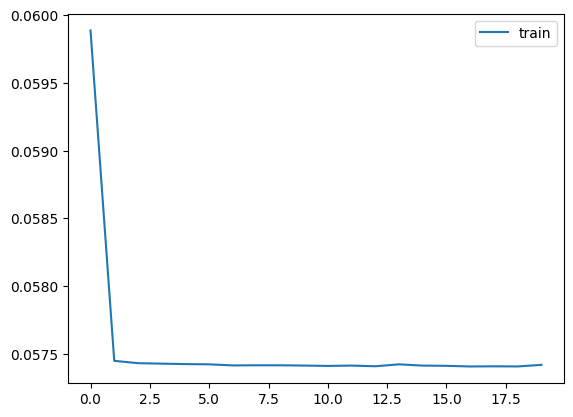

In [53]:
plt.plot(history.history['loss'], label='train')
# plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [48]:
model = load_model('models/best_lstm_model.h5')

In [54]:
train_predictions = model.predict(x_train)
test_predictions = model.predict(x_test)

112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


In [55]:
# Inverse transform the predictions and true values to get back to the actual scale

# If you used a scaler for y, e.g., MinMaxScaler, and you have it as `y_scaler`
# The y_train and train_predictions may need to be reshaped for inverse_transform

# Assuming y_scaler is available, and that predictions/targets are 2D
# Only inverse transform the first column if scaler was fit on all features
train_predictions_actual = scaler.inverse_transform(
    np.concatenate([
        train_predictions,
        np.zeros((train_predictions.shape[0], scaler.n_features_in_ - train_predictions.shape[1]))
    ], axis=1)
)[:, 0].reshape(-1, 1)
# Pad y_train with zeros to match the number of features used in scaler, then inverse transform and select target column
# Ensure y_train is at least 2D for correct concatenation along axis=1
if y_train.ndim == 1:
    y_train_2d = y_train.reshape(-1, 1)
else:
    y_train_2d = y_train

y_train_padded = np.concatenate([
    y_train_2d,
    np.zeros((y_train_2d.shape[0], scaler.n_features_in_ - 1))
], axis=1)
# Fix: Use the correct scaler for y, not the whole input scaler if available.
# If you only scaled the target variable y, use that scaler (e.g. y_scaler) here.
# Otherwise, for single-output with full-feature fit, pad to scaler.n_features_in_
if hasattr(scaler, 'n_features_in_') and y_train_padded.shape[1] != scaler.n_features_in_:
    n_missing = scaler.n_features_in_ - y_train_padded.shape[1]
    if n_missing > 0:
        y_train_padded = np.concatenate([
            y_train_padded,
            np.zeros((y_train_padded.shape[0], n_missing))
        ], axis=1)
    elif n_missing < 0:
        y_train_padded = y_train_padded[:, :scaler.n_features_in_]

y_train_actual = scaler.inverse_transform(y_train_padded)[:, 0].reshape(-1, 1)

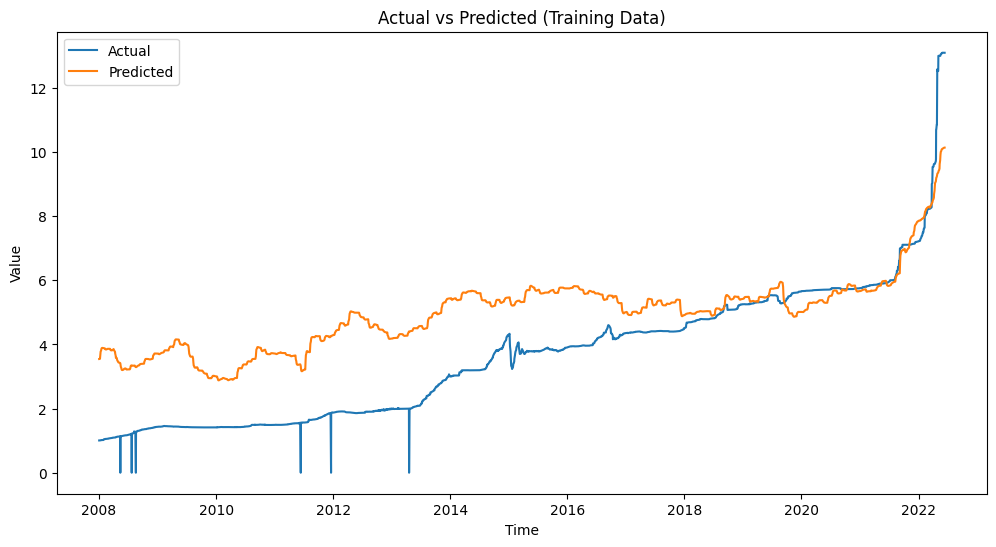

In [56]:


# Create an x-axis of dates for the training period, if available
# If your y_train came from a dataframe with Date index or column use it
# Otherwise, just use np.arange or dataset index matching the training rows

# Example: If you used a DataFrame and have its index as dates:
# train_dates = dataset.index[:len(y_train_actual)]
# If unavailable, default to row indices
# Use actual date values from the training set if available
# Assuming you have a DataFrame or Series with aligned dates for the y_train data
# For example, if your training set comes from splitting a DataFrame with a Date index:
if 'train_idx' in locals():
    # Use train indices in original order (oldest to latest), we'll reverse later for plotting
    train_dates = dataset.index[train_idx]
elif hasattr(dataset, 'index') and len(dataset.index) >= len(y_train_actual):
    train_dates = dataset.index[:len(y_train_actual)]
elif 'train_dates' in globals():
    train_dates = train_dates
else:
    raise ValueError("No date information found for training set.")

# Reverse both dates and actuals/predictions so that the latest date appears first on the plot,
# and corresponding y values are matched in time
train_dates = train_dates[::-1]
y_train_actual = y_train_actual[::-1]
train_predictions_actual = train_predictions_actual[::-1]

plt.figure(figsize=(12, 6))
plt.plot(train_dates, y_train_actual, label='Actual')
plt.plot(train_dates, train_predictions_actual, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs Predicted (Training Data)')
plt.legend()
plt.show()


In [57]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# y_train_actual and train_predictions_actual should be aligned arrays of actual vs predicted, already reversed above
# Flatten to 1D for metric functions if necessary
y_true = y_train_actual.flatten()
y_pred = train_predictions_actual.flatten()

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print(f"Training MSE: {mse:.6f}")
print(f"Training MAE: {mae:.6f}")
print(f"Training RMSE: {rmse:.6f}")
print(f"Training R2 Score: {r2:.6f}")


Training MSE: 3.069820
Training MAE: 1.471920
Training RMSE: 1.752090
Training R2 Score: 0.272223
